In [2]:
# %% [markdown]
"""
# Semi-Supervised Learning for Chemistry: Complementary Skills & Techniques

This notebook demonstrates how to apply semi-supervised learning to a chemistry problem.
We simulate a synthetic dataset where each sample represents a chemical compound described by
multiple descriptors (e.g., molecular weight, LogP, number of hydrogen bond donors, etc.).
The goal is to classify compounds (for example, as "Active" or "Inactive").

In this notebook, we:
- Generate and visualize a synthetic chemical descriptor dataset.
- Create a semi-supervised learning scenario by masking many labels.
- Apply semi-supervised learning (LabelSpreading) to predict compound activity.
- Compare semi-supervised results with a fully supervised model (Support Vector Machine).
- Explore advanced visualization techniques (PCA, t-SNE) to analyze the descriptor space.
- Simulate a self-training approach using Logistic Regression.
- Investigate feature importance for interpretability.
- Demonstrate how to save and load a trained model.

Let’s begin by importing the necessary libraries.
"""

'\n# Semi-Supervised Learning for Chemistry: Complementary Skills & Techniques\n\nThis notebook demonstrates how to apply semi-supervised learning to a chemistry problem.\nWe simulate a synthetic dataset where each sample represents a chemical compound described by\nmultiple descriptors (e.g., molecular weight, LogP, number of hydrogen bond donors, etc.).\nThe goal is to classify compounds (for example, as "Active" or "Inactive").\n\nIn this notebook, we:\n- Generate and visualize a synthetic chemical descriptor dataset.\n- Create a semi-supervised learning scenario by masking many labels.\n- Apply semi-supervised learning (LabelSpreading) to predict compound activity.\n- Compare semi-supervised results with a fully supervised model (Support Vector Machine).\n- Explore advanced visualization techniques (PCA, t-SNE) to analyze the descriptor space.\n- Simulate a self-training approach using Logistic Regression.\n- Investigate feature importance for interpretability.\n- Demonstrate how t

In [3]:
# %% [code]
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.semi_supervised import LabelSpreading
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import ListedColormap
import joblib

# Set seed for reproducibility
np.random.seed(123)
#plt.style.use('seaborn-whitegrid')
print("Libraries imported.")

Libraries imported.


In [4]:
# %% [markdown]
"""
# Cell 2: Generate a Synthetic Chemical Dataset

We simulate a dataset where each compound is represented by 4 chemical descriptors:
- Descriptor 1: e.g., Molecular Weight
- Descriptor 2: e.g., LogP (lipophilicity)
- Descriptor 3: e.g., Number of Hydrogen Bond Donors (HBD)
- Descriptor 4: e.g., Topological Polar Surface Area (TPSA)

We generate 1000 samples (compounds) and assign binary labels (Active vs. Inactive).
To mimic real-life challenges in chemistry, only a small portion of the data is labeled.
"""

# %% [code]
# Cell 2: Synthetic Data Generation for Chemical Descriptors
n_samples = 1000
n_features = 4  # chemical descriptors

# Create synthetic classification data
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=3,
                           n_redundant=0, n_clusters_per_class=2, flip_y=0.07,
                           class_sep=1.2, random_state=123)

# Create a DataFrame with synthetic chemical descriptors
descriptor_names = ["Mol_Weight", "LogP", "HBD", "TPSA"]
df_chem = pd.DataFrame(X, columns=descriptor_names)
df_chem["True_Activity"] = y

# In a semi-supervised setting, only a small percentage of the compounds are labeled.
# We mark unlabeled samples with -1.
percent_labeled = 0.25  # 25% labeled
n_labeled = int(n_samples * percent_labeled)
indices_labeled = np.random.choice(n_samples, n_labeled, replace=False)
y_semi = -np.ones(n_samples, dtype=int)
y_semi[indices_labeled] = y[indices_labeled]
df_chem["Semi_Activity"] = y_semi

print(f"Generated synthetic chemical dataset with {n_samples} compounds.")
print(f"Number of labeled compounds: {n_labeled}")


Generated synthetic chemical dataset with 1000 compounds.
Number of labeled compounds: 250


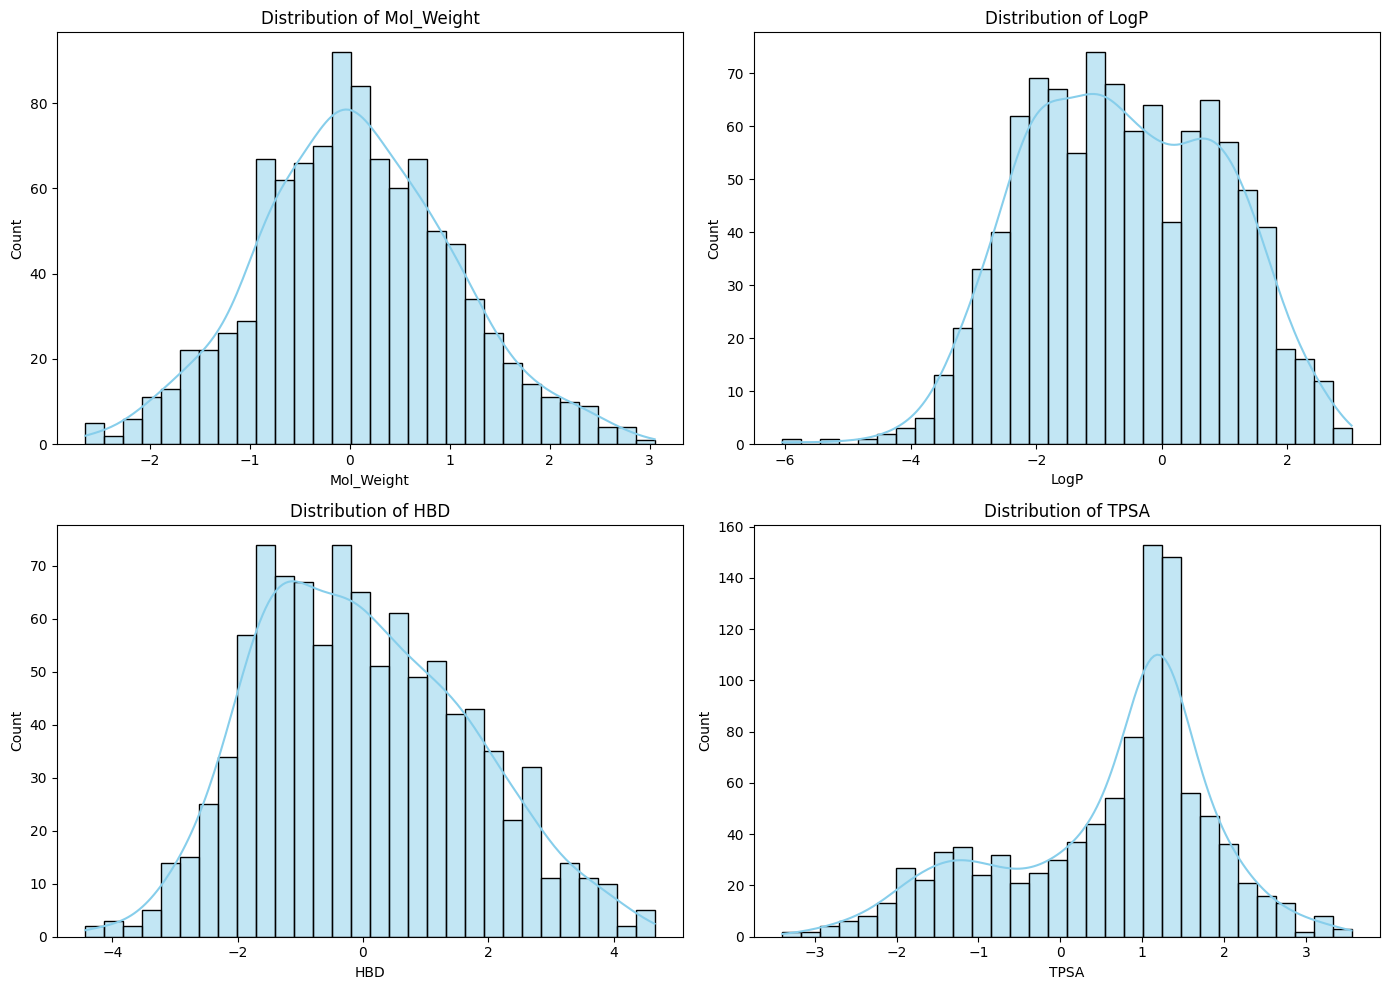

In [5]:
# %% [markdown]
"""
# Cell 3: Visualize the Chemical Descriptor Distributions

We now plot histograms for each chemical descriptor.
This helps us understand the distribution of features, which can be critical in model training.
"""

# %% [code]
# Cell 3: Visualize Descriptor Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, feature in enumerate(descriptor_names):
    sns.histplot(df_chem[feature], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

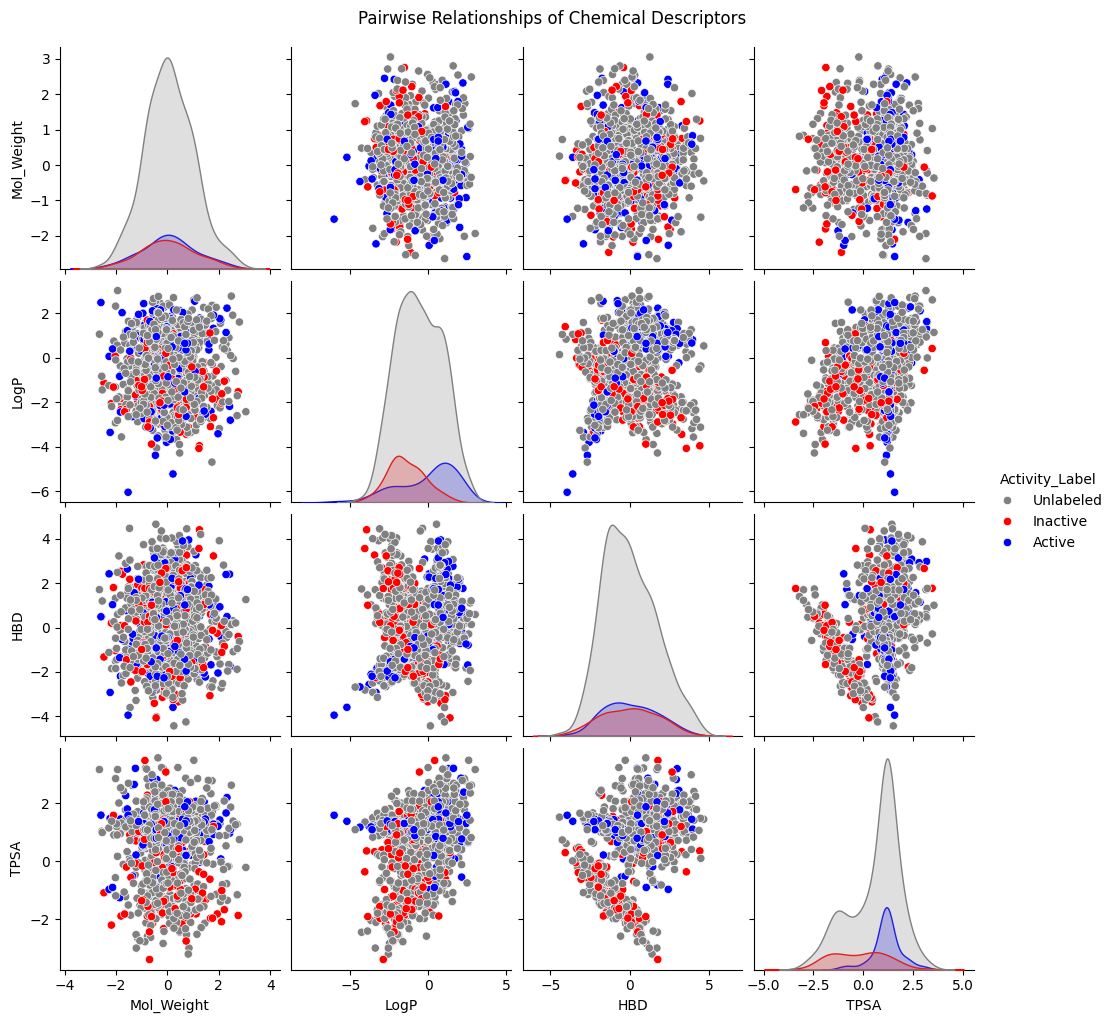

In [6]:
# %% [markdown]
"""
# Cell 4: Pairwise Relationships and Label Visualization

A pairplot helps us visualize the relationship between different chemical descriptors.
Labeled compounds are highlighted, whereas unlabeled ones are shown in gray.
"""

# %% [code]
# Cell 4: Pairplot for Chemical Descriptors
df_pair = df_chem.copy()
# Create a new column for visualization: if unlabeled, set label as 'Unlabeled'
df_pair["Activity_Label"] = df_pair["Semi_Activity"].apply(lambda x: "Active" if x == 1 else ("Inactive" if x == 0 else "Unlabeled"))

sns.pairplot(df_pair, vars=descriptor_names, hue="Activity_Label", palette={"Active": "blue", "Inactive": "red", "Unlabeled": "gray"}, diag_kind="kde")
plt.suptitle("Pairwise Relationships of Chemical Descriptors", y=1.02)
plt.show()

In [7]:
# %% [markdown]
"""
# Cell 5: Applying Semi-Supervised Learning with LabelSpreading

We now apply the LabelSpreading algorithm to propagate labels from the few labeled compounds to the unlabeled ones.
LabelSpreading uses a similarity-based approach (here using the RBF kernel) to learn from the structure of the data.
"""

# %% [code]
# Cell 5: Train LabelSpreading Model
label_spread = LabelSpreading(kernel='rbf', gamma=15, max_iter=50)
label_spread.fit(X, y_semi)
y_pred_semi = label_spread.transduction_

# Add predictions to the DataFrame
df_chem["Pred_Activity"] = y_pred_semi

print("Semi-supervised learning applied with LabelSpreading.")
print("Sample of predicted activity labels:")
print(df_chem[["True_Activity", "Semi_Activity", "Pred_Activity"]].head(10))

Semi-supervised learning applied with LabelSpreading.
Sample of predicted activity labels:
   True_Activity  Semi_Activity  Pred_Activity
0              0             -1              0
1              1             -1              1
2              0             -1              0
3              0             -1              0
4              0              0              0
5              1              1              1
6              0             -1              0
7              0              0              0
8              0             -1              0
9              1             -1              1


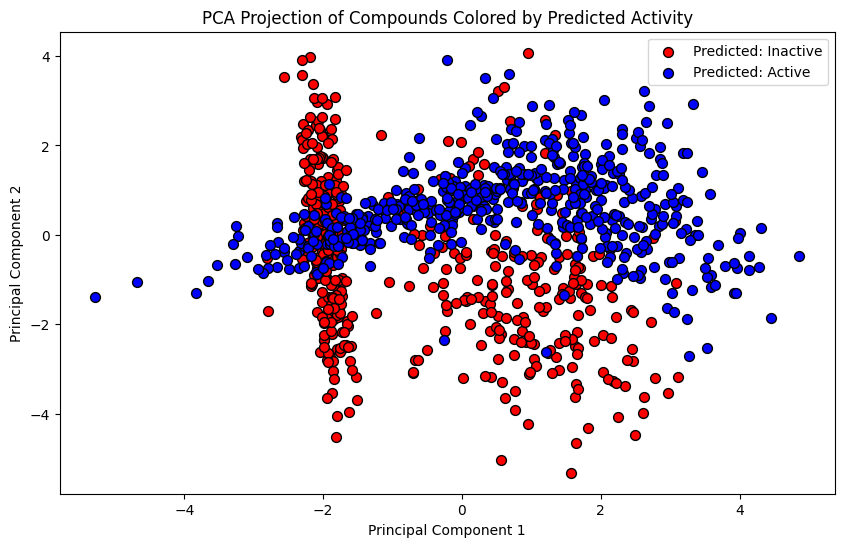

In [8]:
# %% [markdown]
"""
# Cell 6: Visualizing Predictions in the Chemical Descriptor Space

Since our data is 4-dimensional, we use PCA to reduce the feature space to 2 dimensions for visualization.
We then plot the compounds colored by their predicted activity from the LabelSpreading model.
"""

# %% [code]
# Cell 6: PCA for Visualization of Predicted Activities
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_chem["PCA1"] = X_pca[:, 0]
df_chem["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
# Plot compounds predicted as Active (blue) and Inactive (red)
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df_chem[df_chem["Pred_Activity"] == label]
    plt.scatter(subset["PCA1"], subset["PCA2"], c=color, marker='o', edgecolor='k', s=50, label=f'Predicted: {"Inactive" if label==0 else "Active"}')

plt.title("PCA Projection of Compounds Colored by Predicted Activity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

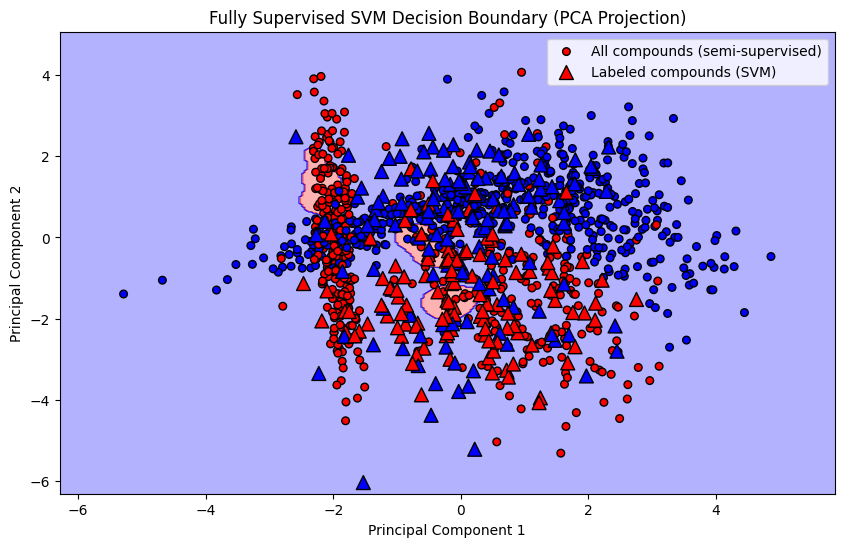

In [9]:
# %% [markdown]
"""
# Cell 7: Fully Supervised Learning Comparison (SVM)

For comparison, we now train a fully supervised Support Vector Machine (SVM) model on only the limited labeled compounds.
We then visualize its decision boundary (after projecting via PCA) and compare it with the semi-supervised results.
"""

# %% [code]
# Cell 7: Fully Supervised SVM Model on Labeled Data
# Extract only labeled samples
X_labeled = X[y_semi != -1]
y_labeled = y[y_semi != -1]

svm_model = SVC(kernel='rbf', gamma=15, probability=True)
svm_model.fit(X_labeled, y_labeled)

# Create a meshgrid in the PCA-reduced space for decision boundary plotting
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Inverse transform the PCA grid to original feature space
# (for this demonstration, we use the PCA grid for visualization only)
grid_points = np.c_[xx.ravel(), yy.ravel()]
# Since our PCA is linear, we can approximate the original features:
X_approx = pca.inverse_transform(grid_points)
Z_svm = svm_model.predict(X_approx)
Z_svm = Z_svm.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_svm, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_semi, cmap=ListedColormap(['red', 'blue']),
            marker='o', edgecolor='k', s=30, label="All compounds (semi-supervised)")
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap=ListedColormap(['red', 'blue']),
            marker='^', edgecolor='k', s=100, label="Labeled compounds (SVM)")
plt.title("Fully Supervised SVM Decision Boundary (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

Accuracy of LabelSpreading: 0.93

Classification Report for Semi-Supervised Model:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       497
           1       0.91      0.95      0.93       503

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Confusion Matrix:
[[449  48]
 [ 23 480]]


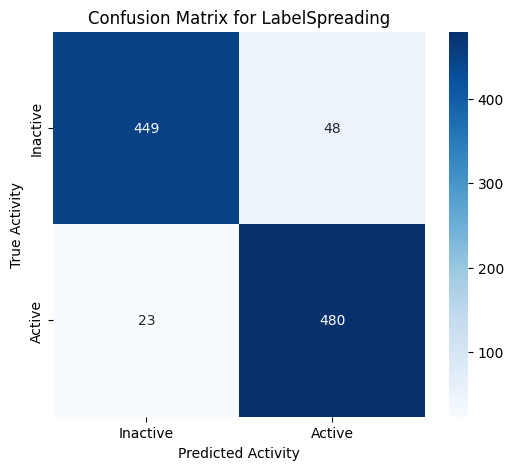

In [10]:
# %% [markdown]
"""
# Cell 8: Model Evaluation

We evaluate the performance of the semi-supervised model using accuracy, classification report, and confusion matrix.
We compare the predicted labels against the true activity labels.
"""

# %% [code]
# Cell 8: Evaluate Semi-Supervised Model
accuracy_semi = accuracy_score(y, y_pred_semi)
print(f"Accuracy of LabelSpreading: {accuracy_semi:.2f}")

print("\nClassification Report for Semi-Supervised Model:")
print(classification_report(y, y_pred_semi))

cm_semi = confusion_matrix(y, y_pred_semi)
print("Confusion Matrix:")
print(cm_semi)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_semi, annot=True, fmt="d", cmap="Blues", xticklabels=["Inactive", "Active"], yticklabels=["Inactive", "Active"])
plt.title("Confusion Matrix for LabelSpreading")
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


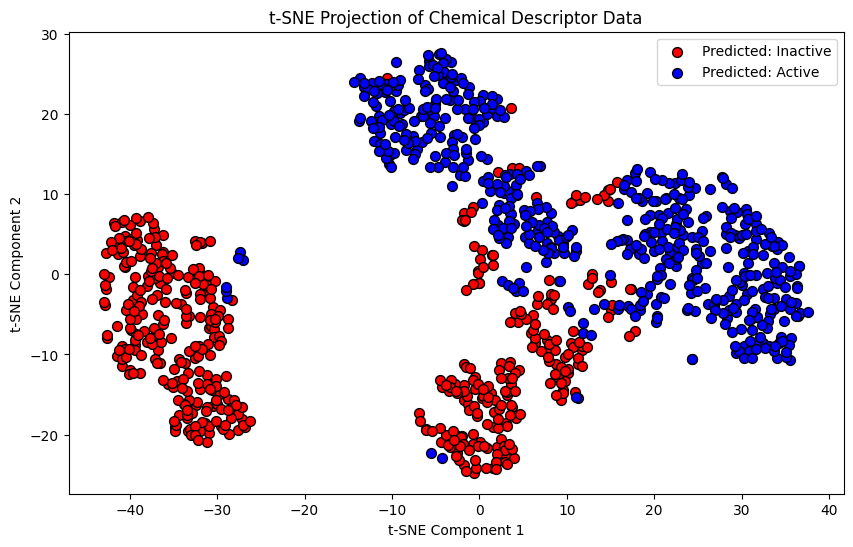

In [11]:
# %% [markdown]
"""
# Cell 9: Advanced Visualization with t-SNE

t-SNE is a non-linear dimensionality reduction technique useful for visualizing complex, high-dimensional data.
We apply t-SNE on the chemical descriptors and visualize the clustering of compounds based on their predicted activity.
"""

# %% [code]
# Cell 9: t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=123)
X_tsne = tsne.fit_transform(X)

df_chem["tSNE1"] = X_tsne[:, 0]
df_chem["tSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df_chem[df_chem["Pred_Activity"] == label]
    plt.scatter(subset["tSNE1"], subset["tSNE2"], c=color, marker='o', edgecolor='k', s=50,
                label=f'Predicted: {"Inactive" if label==0 else "Active"}')
plt.title("t-SNE Projection of Chemical Descriptor Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

Adding 76 new pseudo-labeled compounds with confidence > 0.96


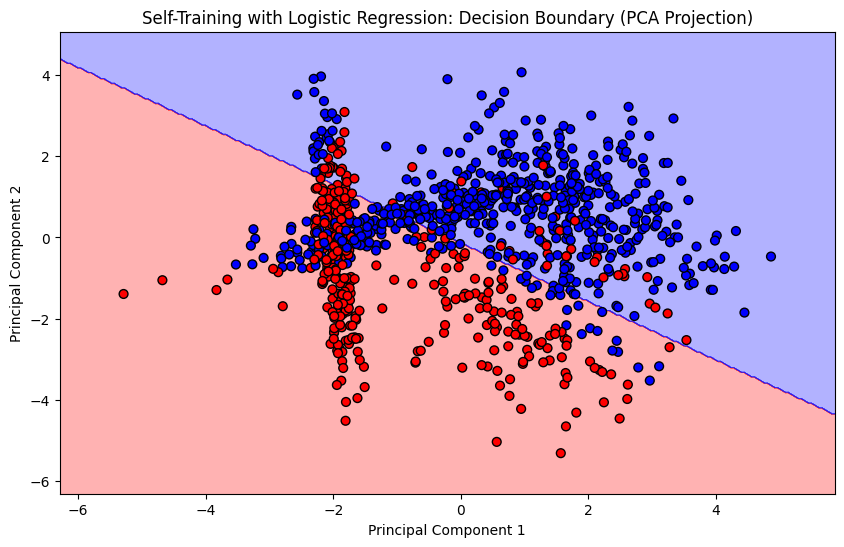

In [12]:
# %% [markdown]
"""
# Cell 10: Self-Training with Logistic Regression

Self-training is another semi-supervised approach where we iteratively label unlabeled data based on model confidence.
In this cell, we simulate one iteration of self-training using Logistic Regression on our chemical dataset.
"""

# %% [code]
# Cell 10: Self-Training Simulation
# Start with only the labeled data
X_self = X_labeled.copy()
y_self = y_labeled.copy()

# Train a logistic regression classifier on the labeled data
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X_self, y_self)

# Predict probabilities for the unlabeled compounds
X_unlabeled = X[y_semi == -1]
probs_unlabeled = lr_model.predict_proba(X_unlabeled)
confidence_unlabeled = np.max(probs_unlabeled, axis=1)

# Define a high confidence threshold to add pseudo-labels
threshold = 0.96
new_indices = np.where(confidence_unlabeled > threshold)[0]
print(f"Adding {len(new_indices)} new pseudo-labeled compounds with confidence > {threshold}")

# Get the new labels
X_new = X_unlabeled[new_indices]
y_new = lr_model.predict(X_new)

# Augment the training set
X_self = np.concatenate([X_self, X_new], axis=0)
y_self = np.concatenate([y_self, y_new], axis=0)

# Retrain the logistic regression classifier on the augmented set
lr_model.fit(X_self, y_self)
y_self_pred = lr_model.predict(X)

# Plot decision boundary using PCA space for visualization
X_self_pca = pca.transform(X)
x_min_self, x_max_self = X_self_pca[:, 0].min() - 1, X_self_pca[:, 0].max() + 1
y_min_self, y_max_self = X_self_pca[:, 1].min() - 1, X_self_pca[:, 1].max() + 1
xx_self, yy_self = np.meshgrid(np.linspace(x_min_self, x_max_self, 300),
                               np.linspace(y_min_self, y_max_self, 300))
grid_self = np.c_[xx_self.ravel(), yy_self.ravel()]
grid_orig = pca.inverse_transform(grid_self)
Z_self = lr_model.predict(grid_orig)
Z_self = Z_self.reshape(xx_self.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx_self, yy_self, Z_self, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_self_pred, cmap=ListedColormap(['red', 'blue']),
            marker='o', edgecolor='k', s=40)
plt.title("Self-Training with Logistic Regression: Decision Boundary (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

<ipython-input-13-6974493e5984>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=descriptor_names, y=importance, palette='magma')


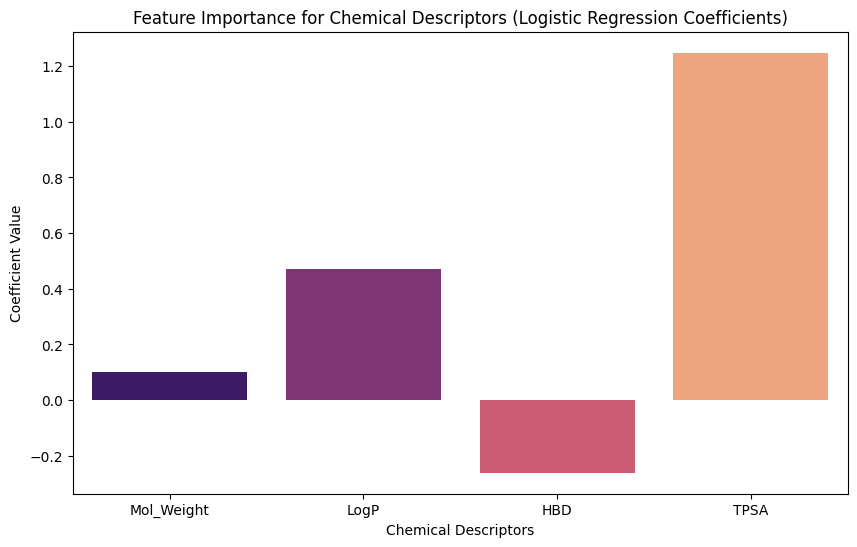

In [13]:
# %% [markdown]
"""
# Cell 11: Feature Importance Analysis

Understanding which chemical descriptors drive model predictions is essential for interpretability.
Here, we analyze feature importance using the coefficients from a logistic regression model trained on labeled data.
"""

# %% [code]
# Cell 11: Feature Importance in Chemical Data
# Retrain Logistic Regression on the full labeled subset for interpretability
lr_importance = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_importance.fit(X_labeled, y_labeled)
importance = lr_importance.coef_[0]

plt.figure(figsize=(10, 6))
sns.barplot(x=descriptor_names, y=importance, palette='magma')
plt.title("Feature Importance for Chemical Descriptors (Logistic Regression Coefficients)")
plt.xlabel("Chemical Descriptors")
plt.ylabel("Coefficient Value")
plt.show()

In [14]:
# %% [markdown]
"""
# Cell 12: Save and Load the Semi-Supervised Model

It is important to save trained models for future use.
Below, we demonstrate how to persist the LabelSpreading model and load it later.
"""

# %% [code]
# Cell 12: Model Persistence
model_file = "chem_label_spreading.pkl"
joblib.dump(label_spread, model_file)
print(f"Semi-supervised model saved as {model_file}.")

# Load the model back
loaded_model = joblib.load(model_file)
print("Loaded model predictions (first 10):", loaded_model.transduction_[:10])

Semi-supervised model saved as chem_label_spreading.pkl.
Loaded model predictions (first 10): [0 1 0 0 0 1 0 0 0 1]


In [15]:

# %% [markdown]
"""
# Cell 13: Summary & Future Directions

In this notebook, we have:
- Generated a synthetic chemical descriptor dataset.
- Visualized descriptor distributions and pairwise relationships.
- Applied semi-supervised learning (LabelSpreading) to predict compound activity.
- Compared results with a fully supervised SVM.
- Visualized data using PCA and t-SNE.
- Demonstrated a self-training approach using Logistic Regression.
- Investigated feature importance for model interpretability.
- Saved and loaded our trained model.

Future work may involve integrating real chemical data, expanding descriptor sets, incorporating domain-specific
knowledge, and exploring more advanced semi-supervised techniques (e.g., deep generative models).

Thank you for exploring semi-supervised learning for chemistry with this notebook!
"""

# %% [markdown]
"""
# End of Notebook

Feel free to modify parameters, extend the analysis, and integrate these techniques into your own chemistry projects.
Happy coding and discovery!
"""


'\n# End of Notebook\n\nFeel free to modify parameters, extend the analysis, and integrate these techniques into your own chemistry projects.\nHappy coding and discovery!\n'